In [44]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import itertools

In [59]:
def get_corners(image_data):
    corners = cv2.goodFeaturesToTrack(image_data, 20, 0.1, 15)
    return corners.astype(np.uint8)

def print_corners(image_data, corners):
    circled_image_data = copy.deepcopy(image_data)
    for idx in corners:
        x, y = idx
        cv2.circle(circled_image_data, (x, y), 3, 255, -1)
    return circled_image_data

def get_patches(image_data, corners):
    height, width = image_data.shape[0], image_data.shape[1]
    patch_stack = np.zeros((corners.shape[0], image_data.shape[-1], 8, 8))
    for idx, corner in enumerate(corners):
        corner_col, corner_row = corner
        up_lim = max(0, corner_row - 3)
        up_padding = up_lim - (corner_row - 3)
        low_lim = min(height - 1, corner_row + 4)
        low_padding = (corner_row + 4) - low_lim
        if low_padding == 0:
            low_padding = -8

        left_lim = max(0, corner_col - 3)
        left_padding = left_lim - (corner_col - 3)

        right_lim = min(width - 1, corner_col + 4)
        right_padding = (corner_col + 4) - right_lim
        if right_padding == 0:
            right_padding = -8

        patch = image_data[up_lim:(low_lim + 1), left_lim:(right_lim + 1), :]
        padding = np.zeros((8, 8, image_data.shape[-1]))
        padding[up_padding:(-1 * low_padding), left_padding:(-1 * right_padding), :] = patch
        padding = np.transpose(padding, (2, 0, 1))
        patch_stack[idx] = padding
    return patch_stack

def get_resnet():
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    model = nn.Sequential(*(list(model.children())[:-1])).double()
    return model

def get_extracted_features(patch_stack):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    patch_stack_tensor = torch.from_numpy(patch_stack)
    model = get_resnet().to(device)
    patch_stack_tensor = patch_stack_tensor.to(device)
    model.eval()
    with torch.no_grad():
        out = model(patch_stack_tensor)
        out = out.reshape(out.size(0), -1)
    return out.to('cpu').numpy()

def get_matches(first_extracted_features, second_extracted_features, first_corners, second_corners):
    best_matches = np.zeros((first_extracted_features.shape[0], 5))
    for idx, f_ext in enumerate(first_extracted_features):
        best_matches[idx, :2] = first_corners[idx]
        best_dist = np.inf
        best_match_idx = -1
        for s_idx, s_ext in enumerate(second_extracted_features):
            dist = np.linalg.norm(f_ext - s_ext)
            if dist < best_dist:
                best_dist = dist
                best_match_idx = s_idx
        best_matches[idx, 2:4] = second_corners[best_match_idx]
        best_matches[idx, 4] = best_dist
    best_matches = best_matches[best_matches[:, -1].argsort()]
    return best_matches

def print_matches(best_matches, first_img_data, second_img_data):
    resulting_img = np.concatenate([first_img_data, second_img_data], axis=1)
    for match_elem in best_matches:
        f_x, f_y, s_x, s_y, _ = match_elem
        f_x, f_y, s_x, s_y = int(f_x), int(f_y), int(s_x), int(s_y)
        cv2.circle(resulting_img, (f_x, f_y), 3, (0, 0, 255), -1)
        cv2.circle(resulting_img, (s_x + first_img_data.shape[1], s_y), 3, (0, 0, 255), -1)
        cv2.line(resulting_img, (f_x, f_y), (s_x + first_img_data.shape[1], s_y), (0, 255, 0))
    return resulting_img

def eight_point_algorithm(first_points, second_points):
    en_first_points = np.concatenate([first_points, np.ones((first_points.shape[0], 1))], axis=1)
    en_second_points = np.concatenate([second_points, np.ones((second_points.shape[0], 1))], axis=1)
    coeff_matrix = np.zeros((en_first_points.shape[0], 9))
    for idx in range(en_first_points.shape[0]):
        coeff_matrix[idx, :] = np.kron(en_second_points[idx, :], en_first_points[idx, :])
    u, s, vh = np.linalg.svd(coeff_matrix)
    return vh[:, -1].reshape((3, 3))

def sampson_distance(remaining_first_points, remaining_second_points, fundamental_matrix):
    en_first_points = np.concatenate([remaining_first_points, np.ones((remaining_first_points.shape[0], 1))], axis=1)
    en_second_points = np.concatenate([remaining_second_points, np.ones((remaining_second_points.shape[0], 1))], axis=1)

    tot_err = 0
    for idx in range(en_first_points.shape[0]):
        nominator = en_first_points[idx] @ fundamental_matrix @ en_second_points[idx]
        nominator = nominator * nominator
        denominator = np.linalg.norm(fundamental_matrix.T @ en_first_points[idx])
        denominator += np.linalg.norm(fundamental_matrix @ en_second_points[idx])
        tot_err += nominator / denominator
    
    return tot_err / en_first_points.shape[0]


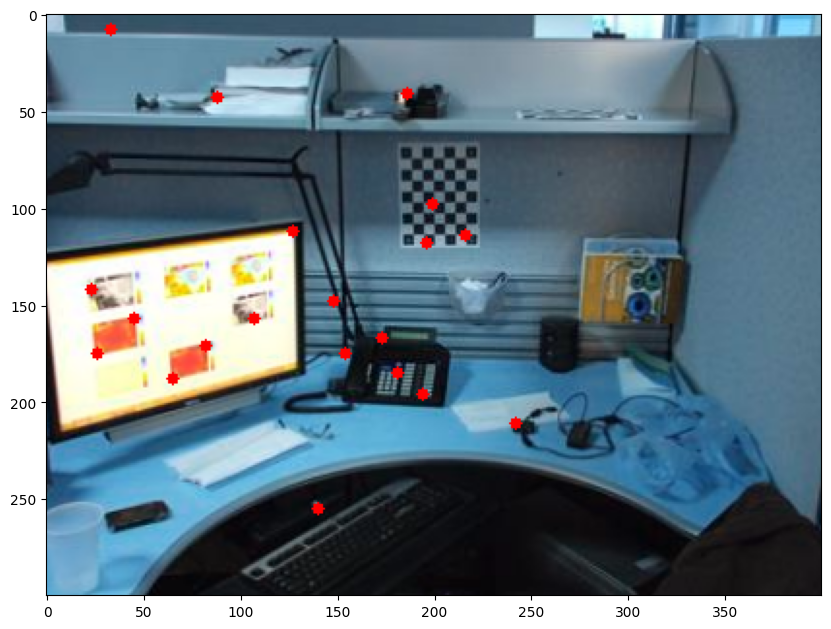

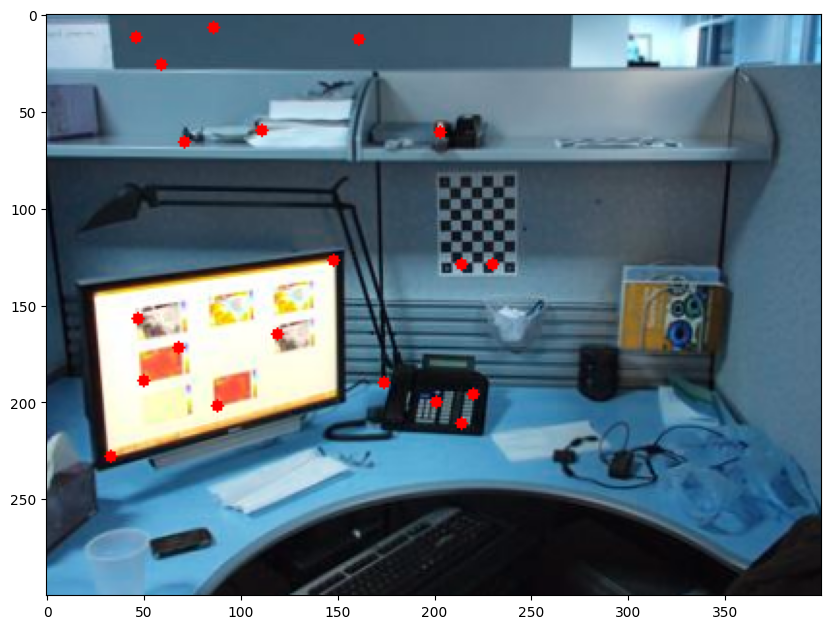

In [3]:
LEFT_IMG_DATA_PATH = os.path.join('.', 'viprectification_deskLeft.png')
RIGHT_IMG_DATA_PATH = os.path.join('.', 'viprectification_deskRight.png')

left_img_data = cv2.imread(LEFT_IMG_DATA_PATH)
right_img_data = cv2.imread(RIGHT_IMG_DATA_PATH)

left_gray = cv2.cvtColor(left_img_data, cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(right_img_data, cv2.COLOR_BGR2GRAY)

left_corners = get_corners(left_gray).squeeze()
right_corners = get_corners(right_gray).squeeze()

plt.figure(figsize=(10, 10))
plt.imshow(print_corners(left_img_data, left_corners))

plt.figure(figsize=(10, 10))
plt.imshow(print_corners(right_img_data, right_corners))

In [4]:
# for both of the images extract 8x8 patches for each corner
left_patches = get_patches(left_img_data, left_corners)
right_patches = get_patches(right_img_data, right_corners)

In [10]:
left_extracted_features = get_extracted_features(left_patches)
right_extracted_features = get_extracted_features(right_patches)

In [70]:
lr_best_matches = get_matches(left_extracted_features, right_extracted_features, left_corners, right_corners)

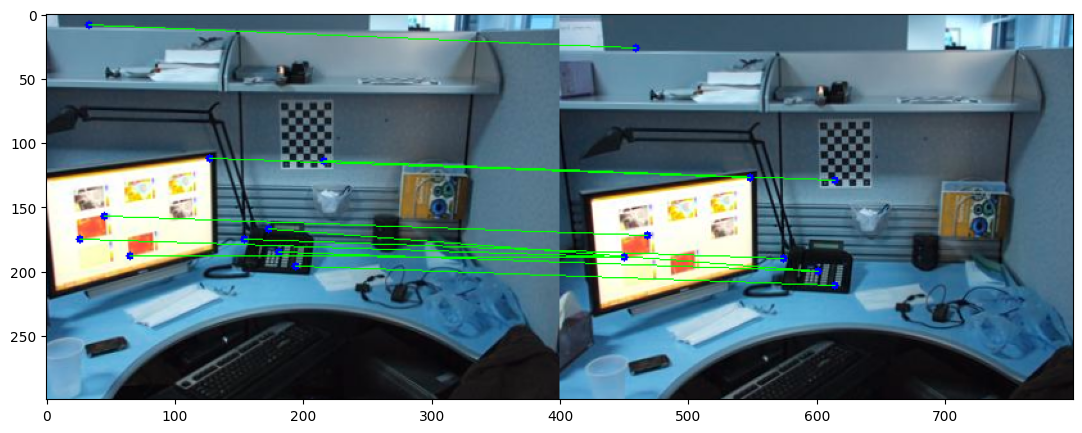

In [71]:
threshold = 10
plt.figure(figsize=(20, 5))
plt.imshow(print_matches(lr_best_matches[:threshold, :], left_img_data, right_img_data))

In [76]:
idx_combination = list(itertools.combinations(range(lr_best_matches.shape[0]), 8))
best_fundamental_matrix = None
best_mean_error = np.inf
best_idx = None
for idx_arg, idx_comb_elem in enumerate(idx_combination):
    idx_comb_elem = list(idx_comb_elem)
    left_points = lr_best_matches[idx_comb_elem, :2]
    right_points = lr_best_matches[idx_comb_elem, 2:4]
    remaining_idx = [x for x in range(lr_best_matches.shape[0]) if x not in idx_comb_elem]
    remaining_left = lr_best_matches[remaining_idx, :2]
    remaining_right = lr_best_matches[remaining_idx, 2:4]
    estimated_fundamental_matrix = eight_point_algorithm(left_points, right_points)
    mean_error = sampson_distance(remaining_left, remaining_right, estimated_fundamental_matrix)
    if best_mean_error > mean_error:
        best_mean_error = mean_error
        best_fundamental_matrix = estimated_fundamental_matrix
        best_idx = idx_comb_elem 
    if (idx_arg + 1) % 100 == 0:
        print('error at iteration {}: {}\nthe best error value: {}\n########'.format(idx_arg, mean_error, best_mean_error))

error at iteration 99: 4663.253662936763
the best error value: 95.64977528612923
########
error at iteration 199: 2036.0310303321266
the best error value: 8.853498265211392
########
error at iteration 299: 6255.807591604606
the best error value: 8.853498265211392
########
error at iteration 399: 5818.15518889338
the best error value: 8.614968910746652
########
error at iteration 499: 4744.176952553166
the best error value: 8.614968910746652
########
error at iteration 599: 5038.798701387862
the best error value: 8.614968910746652
########
error at iteration 699: 573.8946846542468
the best error value: 8.614968910746652
########
error at iteration 799: 2770.851862983642
the best error value: 8.614968910746652
########
error at iteration 899: 5225.730032266575
the best error value: 8.614968910746652
########
error at iteration 999: 7118.440169084984
the best error value: 8.614968910746652
########
error at iteration 1099: 198.16243897485302
the best error value: 8.614968910746652
#######

In [77]:
print('fundamental matrix which produces the best error:\n{}\nthe best mean error: {}'.format(best_fundamental_matrix, best_mean_error))

fundamental matrix which produces the best error:
[[-3.39596043e-05  1.19941410e-06  2.32407070e-05]
 [ 3.14109140e-05 -5.29021011e-05 -1.52676958e-02]
 [ 1.54647327e-02  7.61973286e-03  9.99734802e-01]]
the best mean error: 0.3552236185744739


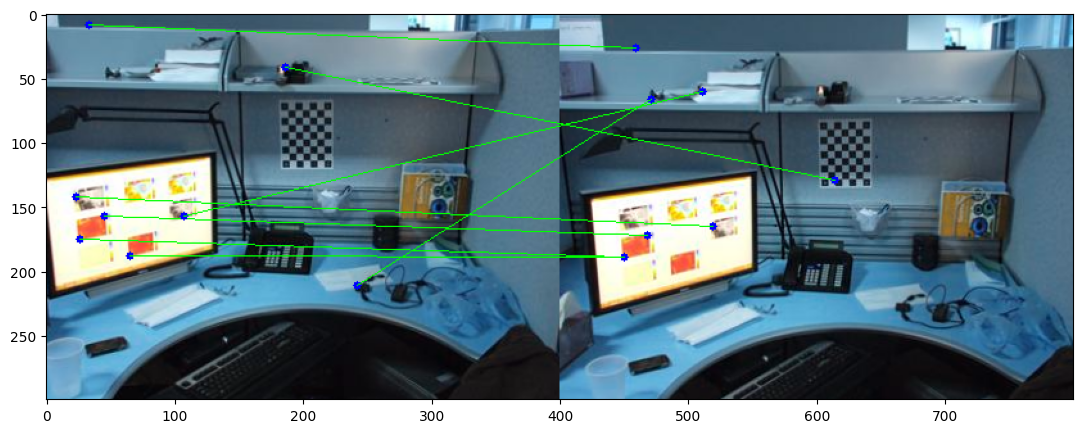

In [78]:
plt.figure(figsize=(20, 5))
plt.imshow(print_matches(lr_best_matches[list(best_idx)], left_img_data, right_img_data))